# MTH 353_Final Project

**Mystery Object Recognition**

This is an image classification model built for the final project of MTH 353.

For the data, we used [Wiki Art](https://www.wikiart.org/en/ancient-egyptian-painting/all-works#!#filterName:all-paintings-chronologically,resultType:masonry), [MET collection](https://www.metmuseum.org/art/collection/search?showOnly=withImage%7CopenAccess&era=1000+B.C.-A.D.+1&q=roman&sortBy=Relevance), and some pictures from Google Search Engine.

To run the model, you need to download the Met_Image_Data and unzip it from your directory.

# Setup

Imports necessary packages

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential

import tensorflow as tf
from keras import layers
from keras.layers import Dense, Flatten, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import os

# Data Loading

**Upload the images in its category folder**
We are using Met_Image_Data in this version


Reference: https://keras.io/examples/vision/image_classification_from_scratch/




In [ ]:
!unzip 'Met_Image_Data.zip'

Archive:  Met_Image_Data.zip
  inflating: __MACOSX/._Met_Image_Data  
... 

**Below is to process the dataset to**

**Egyptian, Greek, Near East**

(Remove Roman)

In [ ]:
# rm -r Met_Image_Data/Roman

**Below is to process the dataset to**

**Egyptian, Greek + Roman**

(Move Roman to Greek, Remove Near East)

In [ ]:
# mv Met_Image_Data/Roman/* Met_Image_Data/Greek

In [ ]:
# rm -d Met_Image_Data/Roman

In [ ]:
# rm -r Met_Image_Data/'Near East'

Directly access the Image Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls '/content/drive/MyDrive/Fall 2023/MTH353/Final Project/Met_Image_Data'

 Egyptian   Greek  'Near East'	 Roman


Generate Dataset

In [ ]:
batch_size = 32
# directory = '/content/drive/MyDrive/Fall 2023/MTH353/Final Project/Met_Image_Data' ## Use this line if directly accessing data from drive
directory = 'Met_Image_Data' ## Use this line if unzipped data in the colab

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory=directory,
    validation_split=0.2,
    subset="both",
    seed=67,
    batch_size = batch_size,
    shuffle=True,
    # crop_to_aspect_ratio=True,  ##save the ratio does not improve the model's performance
)

Found 600 files belonging to 2 classes.
Using 480 files for training.
Using 120 files for validation.


Check class names

In [ ]:
class_names = train_ds.class_names
class_names

['Egyptian', 'Greek']

Plot Dataset

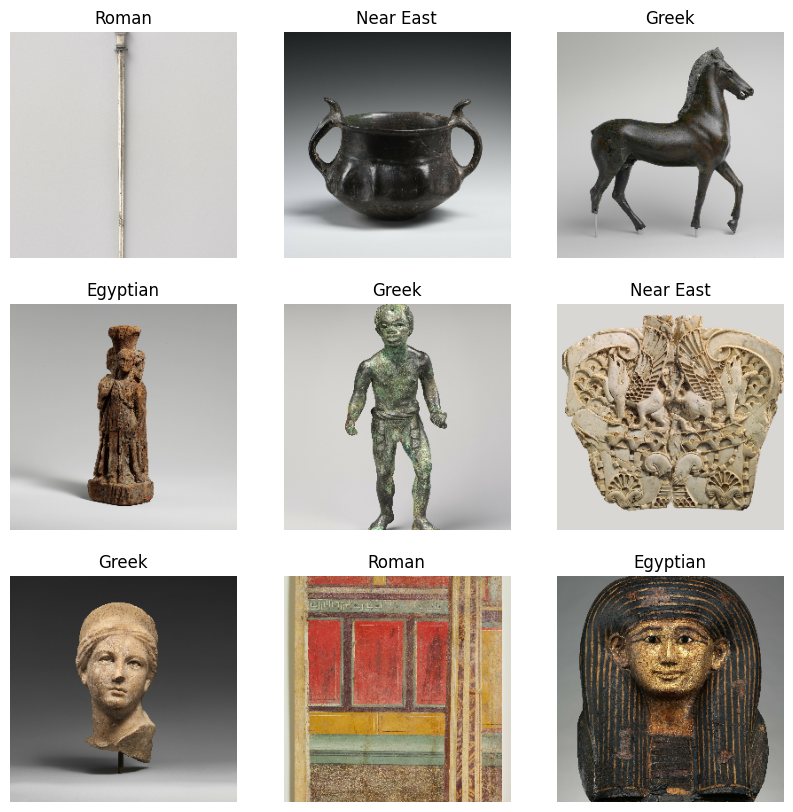

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Preprocessing

Image Augmentation

This step is to artificially introduce sample diversity by applying random yet realistic transformations to the training images

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Visualize Image Augementation Result

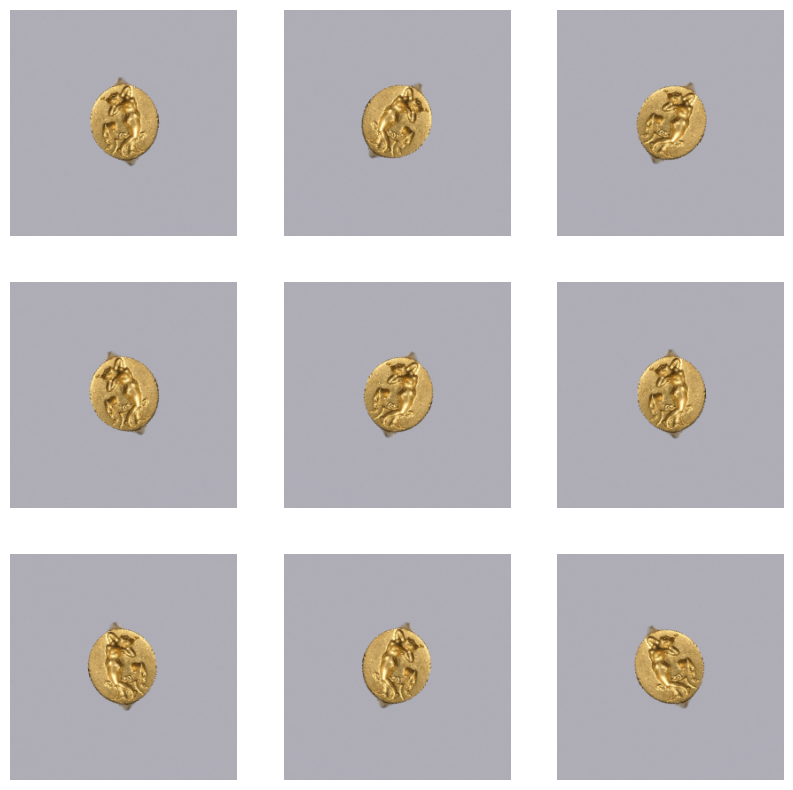

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Preprocess the Data

Configure the dataset for performance
Apply data augmentation to the training dataset. Use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Model Setup

Build the 1st model

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

Make & Compile the 1st model

In [ ]:
image_size = (256,256)
model1 = make_model(input_shape=image_size + (3,), num_classes=4)
# keras.utils.plot_model(model1, show_shapes=True) ## Display the flowchart of the model

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Try a 2nd moedel

In [ ]:
num_classes = 4

model2 = Sequential([
  layers.Rescaling(1./255,input_shape=(256,256,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# keras.utils.plot_model(model2, show_shapes=True)

Compile the 2nd model

*From_logits make this model compatible from both categorical crossentropy & binary crossentropy

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Training



Train the 1st model

In [ ]:
epochs = 15

history = model1.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds)

Epoch 1/10
19/19 [==============================] - 885s 44s/step - loss: 1.3649 - accuracy: 0.4200 - val_loss: 1.3718 - val_accuracy: 0.3600
Epoch 2/10
19/19 [==============================] - 857s 44s/step - loss: 1.2659 - accuracy: 0.4167 - val_loss: 1.3603 - val_accuracy: 0.3933
Epoch 3/10
19/19 [==============================] - 874s 45s/step - loss: 1.2035 - accuracy: 0.4450 - val_loss: 1.3264 - val_accuracy: 0.3933
Epoch 4/10
19/19 [==============================] - 858s 44s/step - loss: 1.1674 - accuracy: 0.4617 - val_loss: 1.3259 - val_accuracy: 0.3933
Epoch 5/10
19/19 [==============================] - 859s 44s/step - loss: 1.0989 - accuracy: 0.5033 - val_loss: 1.3148 - val_accuracy: 0.3800
Epoch 6/10
19/19 [==============================] - 867s 44s/step - loss: 1.1382 - accuracy: 0.4967 - val_loss: 1.2993 - val_accuracy: 0.3933
Epoch 7/10
19/19 [==============================] - 859s 44s/step - loss: 1.1532 - accuracy: 0.4800 - val_loss: 1.2796 - val_accuracy: 0.3933
Epoch 

Train the 2nd model

In [ ]:
epochs=25
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
15/15 [==============================] - 75s 4s/step - loss: 1.1701 - accuracy: 0.5250 - val_loss: 0.7007 - val_accuracy: 0.4917
Epoch 2/25
15/15 [==============================] - 72s 4s/step - loss: 0.6897 - accuracy: 0.5729 - val_loss: 0.6813 - val_accuracy: 0.5333
Epoch 3/25
15/15 [==============================] - 73s 4s/step - loss: 0.6593 - accuracy: 0.6083 - val_loss: 0.6860 - val_accuracy: 0.5583
Epoch 4/25
15/15 [==============================] - 75s 4s/step - loss: 0.6378 - accuracy: 0.6208 - val_loss: 0.6790 - val_accuracy: 0.5667
Epoch 5/25
15/15 [==============================] - 70s 4s/step - loss: 0.6315 - accuracy: 0.6313 - val_loss: 0.6979 - val_accuracy: 0.5500
Epoch 6/25
15/15 [==============================] - 72s 4s/step - loss: 0.5996 - accuracy: 0.6667 - val_loss: 0.6861 - val_accuracy: 0.5750
Epoch 7/25
15/15 [==============================] - 82s 4s/step - loss: 0.5985 - accuracy: 0.6979 - val_loss: 0.6928 - val_accuracy: 0.5667
Epoch 8/25
15/15 [==

Visualize Loss & Accuracy

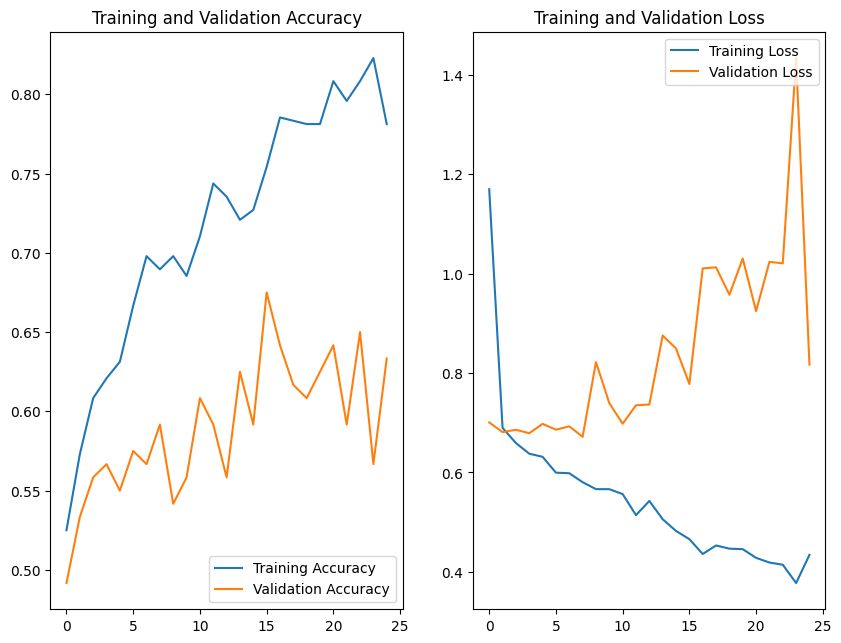

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 7.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Evaluation

Make final prediction on validation set

In [ ]:
y_predictions = model2.predict(val_ds)
y_pred_class = [np.argmax(tf.nn.softmax(y_prediction)) for y_prediction in y_predictions] #returns the model's prediction
y_true = np.concatenate([y for x, y in val_ds], axis=0)

4/4 [==============================] - 8s 2s/step


Create a confusion matrix to visualize the overall result

([<matplotlib.axis.YTick at 0x7caac935ce50>,
 [Text(0, 0.5, 'Egyptian'), Text(0, 1.5, 'Greek')])

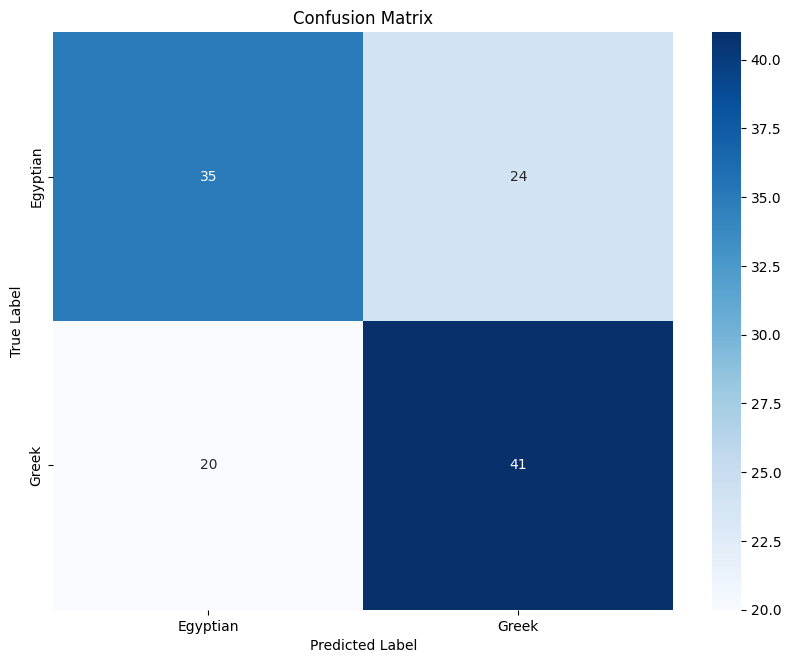

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_class)
fig, ax = plt.subplots(figsize=(10,7.5))
ax = sns.heatmap(confusion_mtx, annot =True, fmt='d', ax=ax, cmap = 'Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.xticks(np.arange(0.5,len(class_names)), class_names)
plt.yticks(np.arange(0.5,len(class_names)), class_names)

Calculate the percentage of TP for each category

In [ ]:
label_arr = ['All'] + class_names
acc_rate_arr = [sum(y_pred_class==y_true)/len(y_pred_class)]
print("The overall accuracy rate is: ", sum(y_pred_class==y_true)/len(y_pred_class))

for i in range(0,len(class_names)):
    probability = confusion_mtx[i]
    label = class_names[i]
    acc_rate = probability[i]/np.sum(probability)
    acc_rate_arr.append(acc_rate)
    print('The accuracy rate for {:10} is: {:2.2%}'.format(label, acc_rate))

The overall accuracy rate is:  0.6333333333333333
The accuracy rate for Egyptian   is: 59.32%
The accuracy rate for Greek      is: 67.21%


Plot out the accuracy rates

[Text(0, 0, '0.633333'), Text(0, 0, '0.59322'), Text(0, 0, '0.672131')]

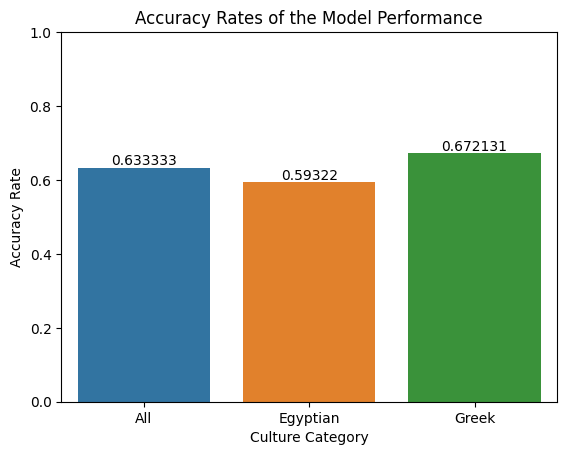

In [ ]:
bar = sns.barplot(x=label_arr, y=acc_rate_arr)
bar.set_ybound(0,1)
bar.set_xlabel('Culture Category')
bar.set_ylabel('Accuracy Rate')
bar.set_title('Accuracy Rates of the Model Performance')
bar.bar_label(bar.containers[0])

#Test#


Predict on mystery images

In [ ]:
test_ds= keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Fall 2023/MTH353/Final Project/Mixed_Categories',
    labels='inferred',
    shuffle=True,
    seed=None,
    validation_split=None,
)

Found 63 files belonging to 4 classes.


In [ ]:
test_predictions = model2.predict(test_ds)

2/2 [==============================] - 3s 527ms/step


In [ ]:
test_pred_class = [np.argmax(tf.nn.softmax(test_prediction)) for test_prediction in test_predictions] #returns the model's prediction
test_true = np.concatenate([y for x, y in test_ds], axis=0)

([<matplotlib.axis.YTick at 0x7caab34cd000>,
 [Text(0, 0.5, 'Greek or Roman'),
  Text(0, 1.5, 'Greek,Egyptian'),
  Text(0, 2.5, 'Greek,Near East'),
  Text(0, 3.5, 'mystery objects')])

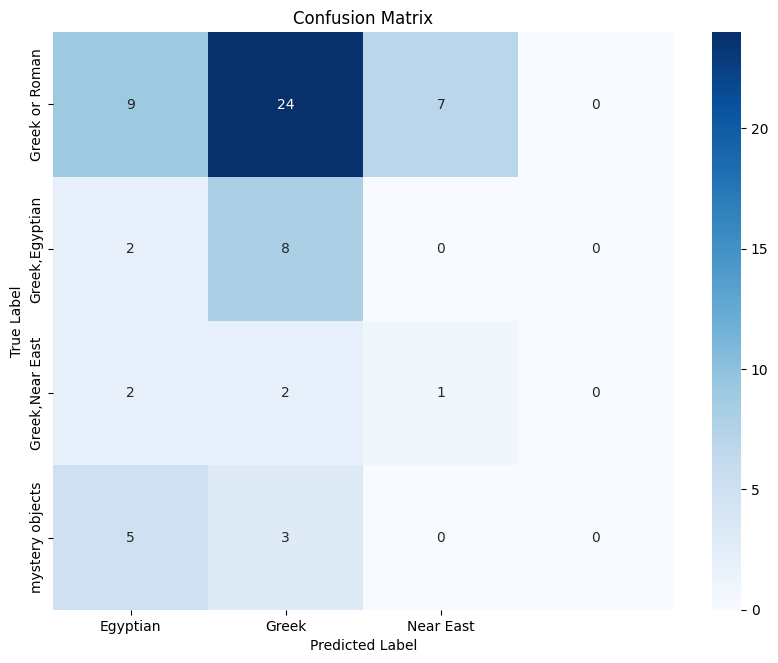

In [ ]:
confusion_mtx = confusion_matrix(test_true, test_pred_class)
fig, ax = plt.subplots(figsize=(10,7.5))
ax = sns.heatmap(confusion_mtx, annot =True, fmt='d', ax=ax, cmap = 'Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.xticks(np.arange(0.5,len(class_names)), class_names)
plt.yticks(np.arange(0.5,len(test_ds.class_names)), test_ds.class_names)